In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import cm
from pprint import pprint

import statsmodels.api as sm
import seaborn as sns
import feature_processing as fp

from sklearn.decomposition import PCA
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif, mutual_info_classif

%matplotlib inline

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [18]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC

In [19]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

# Importing/processing data
- Import binary-categorical data and ordinal/semi-continuous data separately
- The feature space in each dataset was selected by univariate feature selection in nb19
    - chi2, f_classif, and mutual_info_classif used
    - Chi and F selections were done with p-value cutoffs at 0.01 and 0.05
    - Chi selection was only used for binary-categorical data that don't contain negative values
- Chi-based and F-based feature spaces were created by combining bin-cat features with ordinal ones
- Dataset with or without extra features that were selected in Mutual Information selection
  but were not in Chi or F selection was created. For that, I only included features in m-info selection
  that were in top 10% in terms of score.

In [4]:
data = pd.read_csv('./data/trainset_digitized.csv')
feature_space = data.iloc[:, :-1]
target = data.iloc[:, -1]

In [3]:
%%time
bincats_chi001 = pd.read_csv('./data/class_associated_bincat_features_chi001.csv')
bincats_chi005 = pd.read_csv('./data/class_associated_bincat_features_chi005.csv')
bincats_F001 = pd.read_csv('./data/class_associated_bincat_features_F001.csv')
bincats_F005 = pd.read_csv('./data/class_associated_bincat_features_F005.csv')
bincats_mi90 = pd.read_csv('./data/class_associated_bincat_features_mi90.csv')

ordinals_F001 = pd.read_csv('./data/class_associated_ordinal_features_F001.csv')
ordinals_F005 = pd.read_csv('./data/class_associated_ordinal_features_F005.csv')
ordinals_mi90 = pd.read_csv('./data/class_associated_ordinal_features_mi90.csv')

CPU times: user 9.94 s, sys: 1.14 s, total: 11.1 s
Wall time: 11.2 s


In [11]:
chi001 = pd.concat([bincats_chi001, ordinals_F001], axis=1)
chi005 = pd.concat([bincats_chi005, ordinals_F005], axis=1)

F001 = pd.concat([bincats_F001, ordinals_F001], axis=1)
F005 = pd.concat([bincats_F005, ordinals_F005], axis=1)

In [15]:
chi001_mi90_fs = list(chi001.columns) + \
                 [f for f in bincats_mi90 if f not in chi001.columns] + \
                 [f for f in ordinals_mi90 if f not in chi001.columns]
chi005_mi90_fs = list(chi005.columns) + \
                 [f for f in bincats_mi90 if f not in chi005.columns] + \
                 [f for f in ordinals_mi90 if f not in chi005.columns]

F001_mi90_fs = list(F001.columns) + \
                 [f for f in bincats_mi90 if f not in F001.columns] + \
                 [f for f in ordinals_mi90 if f not in F001.columns]
F005_mi90_fs = list(F005.columns) + \
                 [f for f in bincats_mi90 if f not in F005.columns] + \
                 [f for f in ordinals_mi90 if f not in F005.columns]

print('chi001 with/without mi90: %d/%d' % (len(chi001_mi90_fs), chi001.shape[1]))
print('chi005 with/without mi90: %d/%d' % (len(chi005_mi90_fs), chi005.shape[1]))
print('F001 with/without mi90: %d/%d' % (len(F001_mi90_fs), F001.shape[1]))
print('F005 with/without mi90: %d/%d' % (len(F005_mi90_fs), F005.shape[1]))

chi001 with/without mi90: 135/126
chi005 with/without mi90: 150/142
F001 with/without mi90: 135/127
F005 with/without mi90: 151/143


In [16]:
chi001_mi90 = feature_space[chi001_mi90_fs]
chi005_mi90 = feature_space[chi005_mi90_fs]
F001_mi90 = feature_space[F001_mi90_fs]
F005_mi90 = feature_space[F005_mi90_fs]

In [27]:
if True:
    chi001.to_csv('./data/chi001.csv', index=False)
    chi005.to_csv('./data/chi005.csv', index=False)
    chi001_mi90.to_csv('./data/chi001_mi90.csv', index=False)
    chi005_mi90.to_csv('./data/chi005_mi90.csv', index=False)
    F001.to_csv('./data/F001.csv', index=False)
    F005.to_csv('./data/F005.csv', index=False)
    F001_mi90.to_csv('./data/F001_mi90.csv', index=False)
    F005_mi90.to_csv('./data/F005_mi90.csv', index=False)

# Classify with Different Datasets

In [23]:
datasets = [chi001, chi005, chi001_mi90, chi005_mi90, F001, F005, F001_mi90, F005_mi90]
datasets_labels = ['chi001', 'chi005', 'chi001_mi90', 'chi005_mi90', 'F001', 'F005', 'F001_mi90', 'F005_mi90']

chi001: Gini=0.267+/-0.007, Best=0.280
chi005: Gini=0.264+/-0.005, Best=0.270
chi001_mi90: Gini=0.270+/-0.009, Best=0.284
chi005_mi90: Gini=0.265+/-0.008, Best=0.279
F001: Gini=0.267+/-0.010, Best=0.289
F005: Gini=0.267+/-0.007, Best=0.276
F001_mi90: Gini=0.263+/-0.009, Best=0.280
F005_mi90: Gini=0.267+/-0.007, Best=0.276
CPU times: user 1h 57min 23s, sys: 41.8 s, total: 1h 58min 5s
Wall time: 20min 44s


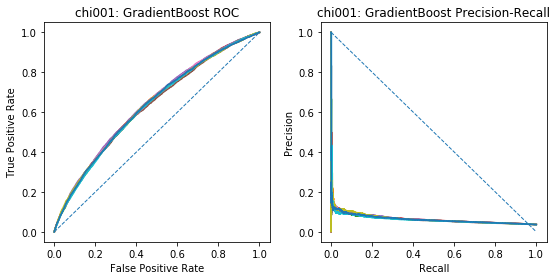

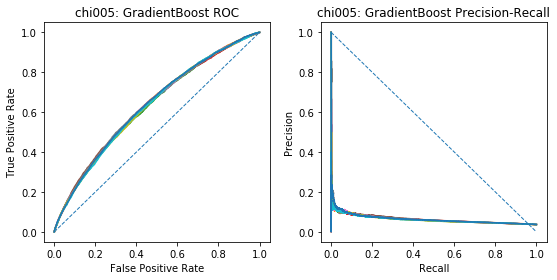

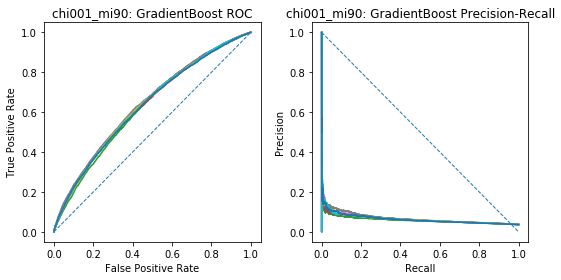

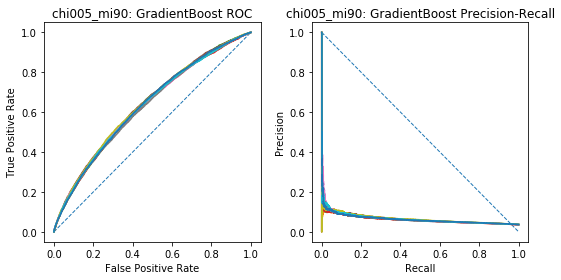

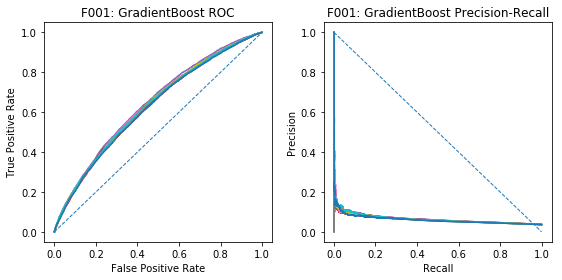

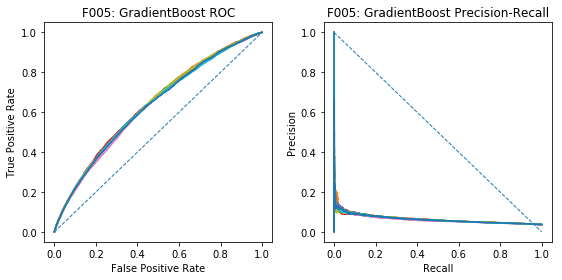

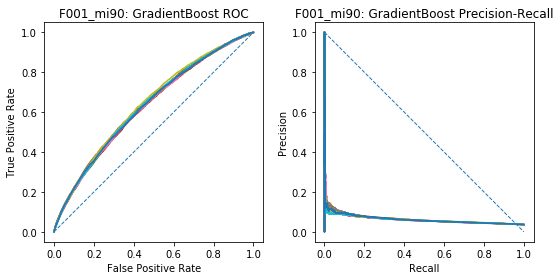

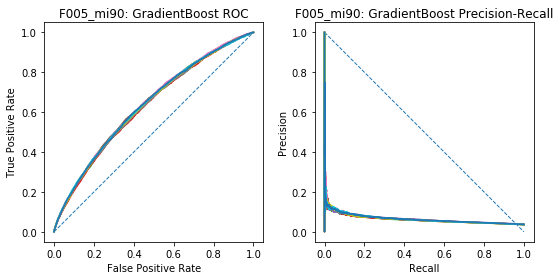

In [28]:
%%time
for j, data in enumerate(datasets):
    label = datasets_labels[j]
    
    fig = plt.figure(figsize=(8, 4))
    ax21 = fig.add_subplot(1, 2, 1)
    ax22 = fig.add_subplot(1, 2, 2)

    neutral_line = np.linspace(0, 1, 10)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

    ginis_xgb = []

    X_new = np.array(data)
    y = np.array(target)

    for i in range(10):

        rstate = None
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=rstate)

        num_class1 = np.sum(y_train)
        num_class1_to_resample = 2 * num_class1
        num_class0_to_resample = int(1 * num_class1_to_resample)

        # First, randomly undersample the majority
        rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
        X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

        # Then use SMOTE to oversample the minority
        smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
        X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

        # GradientBoost
        clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
        clf.fit(X_res, y_res)

        y_pred2 = clf.predict(X_test)
        y_proba2 = clf.predict_proba(X_test)
        ginis_xgb.append(my_gini(y_test, y_proba2))
        report2 = classification_report(y_test, y_pred2, digits=4,
                                       labels=None, target_names=None)

        precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
        fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
        ax21.plot(fpr2, tpr2)
        ax21.set_xlabel('False Positive Rate')
        ax21.set_ylabel('True Positive Rate')
        ax21.set_title('%s: GradientBoost ROC' % label)
        ax22.plot(recall2, precision2)
        ax22.set_xlabel('Recall')
        ax22.set_ylabel('Precision')
        ax22.set_title('%s: GradientBoost Precision-Recall' % label)

    plt.tight_layout()

    print('%s: Gini=%.3f+/-%.3f, Best=%.3f' % (label, np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

### Comment
The selection by Chi and F statistic yields almost identical sets of features, which perform almost identically. Significance level appears to slightly affect the result and more stringent cutoff at pval=0.01 appears to perform better than that at 0.05. Including features that are not in Chi or F but in Mutual_Info screen seems to reduce performance slightly on average, so I can probably use Chi or F selection at significance level of pval<0.01.

# Comparing Chi and F selection at significance level of 0.01 (more CV)
- F001 feature space has one extra feature compared to chi001 space. The above analysis with limited number of CVs
  appeared to give slightly higher variance for F001 results (more sensitive to train_test split?) than chi001.
- Test if that's the case by increasing the numer of CVs and compare just those two datasets.

In [29]:
datasets2 = [chi001, F001]
datasets_labels2 = ['chi001', 'F001']

chi001: Gini=0.263+/-0.009, Best=0.286
F001: Gini=0.269+/-0.007, Best=0.281
CPU times: user 1h 20min 10s, sys: 28.5 s, total: 1h 20min 39s
Wall time: 13min 51s


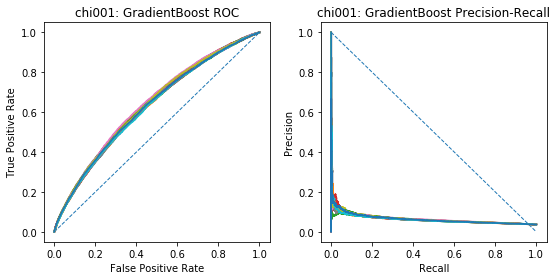

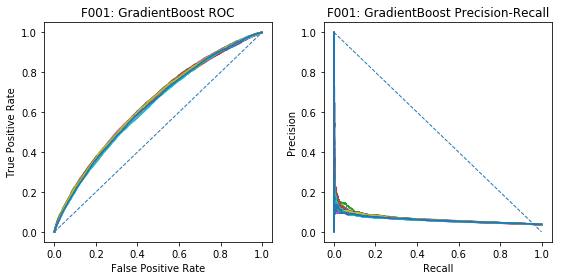

In [30]:
%%time
for j, data in enumerate(datasets2):
    label = datasets_labels2[j]
    
    fig = plt.figure(figsize=(8, 4))
    ax21 = fig.add_subplot(1, 2, 1)
    ax22 = fig.add_subplot(1, 2, 2)

    neutral_line = np.linspace(0, 1, 10)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

    ginis_xgb = []

    X_new = np.array(data)
    y = np.array(target)

    for i in range(30):

        rstate = None
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=rstate)

        num_class1 = np.sum(y_train)
        num_class1_to_resample = 2 * num_class1
        num_class0_to_resample = int(1 * num_class1_to_resample)

        # First, randomly undersample the majority
        rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
        X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

        # Then use SMOTE to oversample the minority
        smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
        X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

        # GradientBoost
        clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
        clf.fit(X_res, y_res)

        y_pred2 = clf.predict(X_test)
        y_proba2 = clf.predict_proba(X_test)
        ginis_xgb.append(my_gini(y_test, y_proba2))
        report2 = classification_report(y_test, y_pred2, digits=4,
                                       labels=None, target_names=None)

        precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
        fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
        ax21.plot(fpr2, tpr2)
        ax21.set_xlabel('False Positive Rate')
        ax21.set_ylabel('True Positive Rate')
        ax21.set_title('%s: GradientBoost ROC' % label)
        ax22.plot(recall2, precision2)
        ax22.set_xlabel('Recall')
        ax22.set_ylabel('Precision')
        ax22.set_title('%s: GradientBoost Precision-Recall' % label)

    plt.tight_layout()

    print('%s: Gini=%.3f+/-%.3f, Best=%.3f' % (label, np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

### Comment
Average performance among 30CVs is slightly better for F001, which has one extra feature, and its variance turned out smaller this time. Maximum score is lower for F001, but since I don't know much about the test set, I'll select on the average performance and use F001 set for further analysis.